In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

In [2]:
slurm=pd.read_csv('fullsample.csv')

In [3]:
slurm.head()

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
0,30616928,RUNNING,2021-07-31T22:15:00,Unknown,2048Mn,0,10:04:00,67-22:14:22,1,1,production,0:0
1,30853133,COMPLETED,2021-08-06T11:36:09,2021-09-05T11:36:32,262144Mn,20604.62M,30-00:00:00,30-00:00:23,1,1,cgw-platypus,0:0
2,30858137,COMPLETED,2021-08-06T19:04:39,2021-09-05T19:04:53,204800Mn,57553.77M,30-00:00:00,30-00:00:14,1,32,cgw-tbi01,0:0
3,30935078,COMPLETED,2021-08-09T16:52:51,2021-09-07T20:52:55,65536Mn,20577.96M,29-04:00:00,29-04:00:04,1,8,cgw-platypus,0:0
4,31364111_2,COMPLETED,2021-08-17T07:45:07,2021-09-10T16:45:24,16384Mn,9733.43M,24-09:00:00,24-09:00:17,1,1,production,0:0


In [4]:
slurm=slurm[(slurm['BEGIN'] != 'Unknown') & (slurm['END'] != 'Unknown')]

### Convert to DateTime Format


In [5]:
slurm['BEGIN']=pd.to_datetime(slurm['BEGIN'], format='%Y-%m-%dT%H:%M:%S')
slurm['END']=pd.to_datetime(slurm['END'], format='%Y-%m-%dT%H:%M:%S')


### Jobs Per Hour Completed

In [6]:
completed_jobs=slurm[slurm['STATE']=='COMPLETED']

In [7]:
bins = pd.date_range(completed_jobs['END'].min()+timedelta(minutes=-60), completed_jobs['END'].max()+timedelta(minutes=60), freq='60min')
df_temp = completed_jobs.loc[:, ['END', 'STATE']]
df_temp["bins"] = pd.cut(df_temp['END'], bins=bins)
df_temp['period'] = [x.right for x in df_temp['bins']]
completed_jobs_hourly = df_temp.groupby(['period', 'STATE']).agg({'END': 'count'}).reset_index()
completed_jobs_hourly

,period,STATE,END
0,2020-10-01 00:10:15,COMPLETED,1
1,2020-10-01 01:10:15,COMPLETED,587
2,2020-10-01 02:10:15,COMPLETED,1127
3,2020-10-01 03:10:15,COMPLETED,1118
4,2020-10-01 04:10:15,COMPLETED,995
...,...,...,...
8919,2021-10-07 17:10:15,COMPLETED,8
8920,2021-10-07 18:10:15,COMPLETED,8
8921,2021-10-07 19:10:15,COMPLETED,8
8922,2021-10-07 20:10:15,COMPLETED,8


<AxesSubplot:xlabel='period'>

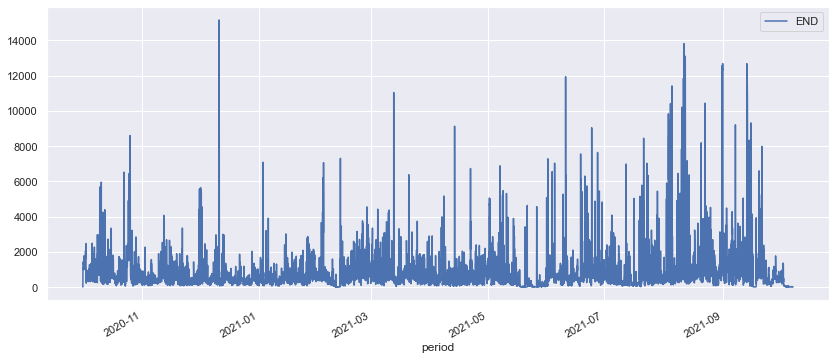

In [8]:
import seaborn as sns
sns.set()

completed_jobs_hourly.plot(kind='line',legend=True, figsize=(14,6), x='period', y='END')
# ax.set_xticklabels(jobs_pivot_tbl.index, rotation=90, ha='right')

!!!!!### Jobs Per Week by Status

In [9]:
from datetime import datetime

In [10]:
#extract date from datestamp
completed_jobs_hourly['Date']=completed_jobs_hourly['period'].dt.date

In [11]:
#extract date/day of the week/week number from datestamp
completed_jobs_hourly['period'].dt.day_name()
completed_jobs_hourly['Day of the Week']=completed_jobs_hourly['period'].dt.day_name()
#df['Week_Number'] = df['Date'].dt.week
completed_jobs_hourly['Week Number']=completed_jobs_hourly['period'].dt.week
completed_jobs_hourly['Year']=completed_jobs_hourly['period'].dt.year

<ipython-input-11-d012e5bba8e7>:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  completed_jobs_hourly['Week Number']=completed_jobs_hourly['period'].dt.week


In [12]:
completed_jobs_hourly.head()

,period,STATE,END,Date,Day of the Week,Week Number,Year
0,2020-10-01 00:10:15,COMPLETED,1,2020-10-01,Thursday,40,2020
1,2020-10-01 01:10:15,COMPLETED,587,2020-10-01,Thursday,40,2020
2,2020-10-01 02:10:15,COMPLETED,1127,2020-10-01,Thursday,40,2020
3,2020-10-01 03:10:15,COMPLETED,1118,2020-10-01,Thursday,40,2020
4,2020-10-01 04:10:15,COMPLETED,995,2020-10-01,Thursday,40,2020


In [13]:
#calculate avg per period and see if this can be improved?

In [14]:
#pd.to_datetime(slurm['REQTIME'], format='%d-%H:%M:%S')
#pd.to_datetime(slurm['USEDTIME'], format='%H:%M:%S')

In [15]:
jobs_by_day_avg=completed_jobs_hourly.groupby('Day of the Week')['END'].mean()

In [16]:
jobs_by_week_num_day=completed_jobs_hourly.groupby(['Week Number','Day of the Week'])['END'].mean()

In [17]:
day_of_the_week=jobs_by_day_avg.to_frame().reset_index()

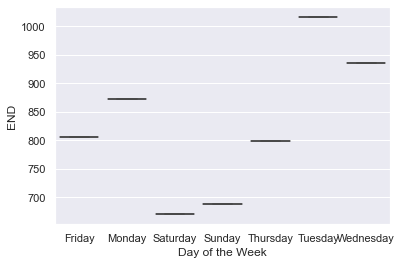

In [18]:

sns.boxplot(x=day_of_the_week['Day of the Week'],y=day_of_the_week['END'])

plt.show()

In [19]:
import scipy.stats as stats

In [20]:
anova1=day_of_the_week.set_index('Day of the Week').T

In [21]:
anova1

Day of the Week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
END,806.088836,871.329403,669.829403,688.674528,798.688563,1016.617323,934.578616


In [22]:

# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(anova1['Friday'],anova1['Monday'], anova1['Saturday'], anova1['Sunday'], anova1['Thursday'], anova1['Tuesday'], anova1['Wednesday'])
print(fvalue, pvalue)


nan nan


C:\Users\U6033919\Anaconda3\lib\site-packages\scipy\stats\stats.py:3688: F_onewayBadInputSizesWarning: all input arrays have length 1.  f_oneway requires that at least one input has length greater than 1.
  warnings.warn(F_onewayBadInputSizesWarning(msg))


In [23]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [24]:
#ols('value ~ C(Day of the Week)', data=day_of_the_week).fit()

In [29]:
jobs_weekday=[len(completed_jobs[completed_jobs['END'].dt.day == x]) for x in range(1,8)]

<BarContainer object of 7 artists>

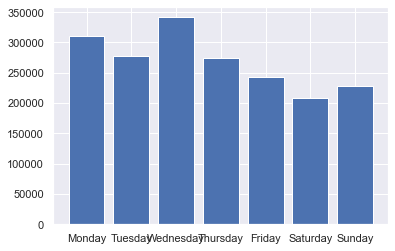

In [30]:
plt.bar(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], jobs_weekday)

In [62]:
days_of_the_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
days_of_the_week_completed=pd.DataFrame({'days_of_the_week': days_of_the_week, 'jobs_completed': jobs_weekday})

In [63]:
days_of_the_week_completed

,days_of_the_week,jobs_completed
0,Monday,311323
1,Tuesday,277362
2,Wednesday,341697
3,Thursday,274168
4,Friday,243411
5,Saturday,208102
6,Sunday,228884


In [47]:
days_of_the_week_completed.sort_values('END')
#jbs['total 7d']=jobs_weekday.rolling('7d', on='END')['JOBID'].count()
#jbs['total 7d']/7

AttributeError: 'list' object has no attribute 'sort_values'

In [33]:
#Verify that all completed jobs have exitcode 0:0
completed_jobs.value_counts('EXITCODE')

EXITCODE
0:0    7375084
dtype: int64

In [34]:
slurm.value_counts('EXITCODE')

EXITCODE
0:0      7383829
1:0         4958
0:15        1887
0:125       1739
0:9         1361
2:0          508
0:7          389
121:0         89
127:0         88
13:0          68
24:0          67
0:11          35
38:0          32
28:0          29
6:0           27
126:0         24
0:6           18
0:2           16
29:0          12
7:0           12
16:0           9
59:0           8
9:0            4
0:40           4
125:0          3
8:0            3
0:105          2
0:12           1
67:0           1
85:0           1
0:98           1
76:0           1
103:0          1
4:0            1
116:0          1
43:0           1
3:0            1
11:0           1
30:0           1
0:8            1
dtype: int64

In [36]:
slurm[slurm['STATE'].str.match(r'CANCELLED')].value_counts('EXITCODE')

EXITCODE
0:0      8744
1:0      2176
0:15     1887
0:9      1361
0:7       389
0:11       35
0:6        18
0:2        16
127:0       5
0:40        4
0:105       2
2:0         2
0:12        1
0:8         1
0:98        1
9:0         1
dtype: int64